In [1]:
from config_A import cfg
from models_A import LSTM_Regression
from dataset_loaders_A import TwitterSentimentVolumePriceXPriceYRegression

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import json
import os
from transformers import BertTokenizer, AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler

In [2]:

# Initialize dataset
train_dataset = TwitterSentimentVolumePriceXPriceYRegression(
    start_date=cfg.train_start_date,
    end_date=cfg.train_end_date,
    day_lag=cfg.dataset_loader_args["day_lag"],
    tweets_per_day=cfg.dataset_loader_args["tweets_per_day"],
    words_per_tweet=cfg.dataset_loader_args["words_per_tweet"],
    twitter_root=cfg.dataset_loader_args["twitter_root"],
    price_root=cfg.dataset_loader_args["price_root"],
)

val_dataset = TwitterSentimentVolumePriceXPriceYRegression(
    start_date=cfg.eval_start_date,
    end_date=cfg.eval_end_date,
    day_lag=cfg.dataset_loader_args["day_lag"],
    tweets_per_day=cfg.dataset_loader_args["tweets_per_day"],
    words_per_tweet=cfg.dataset_loader_args["words_per_tweet"],
    twitter_root=cfg.dataset_loader_args["twitter_root"],
    price_root=cfg.dataset_loader_args["price_root"],
)

test_dataset = TwitterSentimentVolumePriceXPriceYRegression(
    start_date=cfg.test_start_date,
    end_date=cfg.test_end_date,
    day_lag=cfg.dataset_loader_args["day_lag"],
    tweets_per_day=cfg.dataset_loader_args["tweets_per_day"],
    words_per_tweet=cfg.dataset_loader_args["words_per_tweet"],
    twitter_root=cfg.dataset_loader_args["twitter_root"],
    price_root=cfg.dataset_loader_args["price_root"],
)



Normalization fitting done for feature Sentiment
Normalization fitting done for feature Twitter_Volume
Normalization fitting done for feature Movement_Percent
Normalization fitting done for feature Open
Normalization fitting done for feature High
Normalization fitting done for feature Low
Normalization fitting done for feature Volume
Normalization fitting done for feature Sentiment
Normalization fitting done for feature Twitter_Volume
Normalization fitting done for feature Movement_Percent
Normalization fitting done for feature Open
Normalization fitting done for feature High
Normalization fitting done for feature Low
Normalization fitting done for feature Volume
Normalization fitting done for feature Sentiment
Normalization fitting done for feature Twitter_Volume
Normalization fitting done for feature Movement_Percent
Normalization fitting done for feature Open
Normalization fitting done for feature High
Normalization fitting done for feature Low
Normalization fitting done for feature

In [21]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=cfg.num_workers)
val_loader = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=cfg.num_workers)
test_loader = DataLoader(test_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=cfg.num_workers)


In [22]:
from models_A import LSTM_Regression
import torch

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cfg.model(cfg, train_dataset.get_input_size()).to(device)


loss_func = cfg.loss_func()
optimizer = cfg.optimizer(model.parameters(), lr=cfg.LEARNING_RATE)


In [23]:
def train_model(model, train_loader, val_loader, loss_func, optimizer, cfg, device):
    best_val_loss = float("inf")
    history = {"epoch": [], "train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}

    for epoch in range(cfg.EPOCHS):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            (sentiment_seq, price_seq), targets = batch  # Adjusted unpacking
            sentiment_seq, price_seq, targets = (
                sentiment_seq.to(device),
                price_seq.to(device),
                targets.to(device).float(),
            )

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model((sentiment_seq, price_seq))

            # Compute loss
            loss = loss_func(outputs.squeeze(), targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute training accuracy
            preds = outputs.squeeze()
            correct_train += ((preds - targets).abs() < 0.05).sum().item()  # Adjust threshold for regression accuracy
            total_train += targets.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch in val_loader:
                (sentiment_seq, price_seq), targets = batch  # Adjusted unpacking
                sentiment_seq, price_seq, targets = (
                    sentiment_seq.to(device),
                    price_seq.to(device),
                    targets.to(device),
                )

                # Forward pass
                outputs = model((sentiment_seq, price_seq))

                # Compute loss
                loss = loss_func(outputs.squeeze(), targets)
                val_loss += loss.item()

                # Compute validation accuracy
                preds = outputs.squeeze()
                correct_val += ((preds - targets).abs() < 0.05).sum().item()  # Adjust threshold for regression accuracy
                total_val += targets.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val

        # Save history
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_accuracy"].append(val_accuracy)

        print(
            f"Epoch [{epoch + 1}/{cfg.EPOCHS}], "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
            f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}"
        )

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Model saved at epoch {epoch + 1} with validation loss: {val_loss:.4f}")

    # Save history to a file
    torch.save(history, "training_history.pth")
    print("Training history saved.")


In [24]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cfg.model(cfg, train_dataset.get_input_size()).to(device)

# Instantiate loss function
loss_func = cfg.loss_func()

# Instantiate optimizer
optimizer = cfg.optimizer(model.parameters(), lr=cfg.LEARNING_RATE)

# Train the model
train_model(model, train_loader, val_loader, loss_func, optimizer, cfg, device)




Epoch [1/60], Train Loss: 0.0494, Train Accuracy: 0.2328, Validation Loss: 0.0078, Validation Accuracy: 0.4387
Model saved at epoch 1 with validation loss: 0.0078
Epoch [2/60], Train Loss: 0.0199, Train Accuracy: 0.3520, Validation Loss: 0.0058, Validation Accuracy: 0.4863
Model saved at epoch 2 with validation loss: 0.0058
Epoch [3/60], Train Loss: 0.0110, Train Accuracy: 0.4408, Validation Loss: 0.0028, Validation Accuracy: 0.6407
Model saved at epoch 3 with validation loss: 0.0028
Epoch [4/60], Train Loss: 0.0067, Train Accuracy: 0.5363, Validation Loss: 0.0017, Validation Accuracy: 0.7804
Model saved at epoch 4 with validation loss: 0.0017
Epoch [5/60], Train Loss: 0.0037, Train Accuracy: 0.6546, Validation Loss: 0.0011, Validation Accuracy: 0.8863
Model saved at epoch 5 with validation loss: 0.0011
Epoch [6/60], Train Loss: 0.0021, Train Accuracy: 0.7676, Validation Loss: 0.0010, Validation Accuracy: 0.8922
Model saved at epoch 6 with validation loss: 0.0010
Epoch [7/60], Train Lo

KeyboardInterrupt: 

In [25]:
@torch.no_grad()
def test_model(model, test_loader, device):
    """
    Test the model on the test dataset.

    Args:
        model: Trained model.
        test_loader: DataLoader for the test dataset.
        device: Device to run the model on.

    Returns:
        predictions: List of predicted values.
        actuals: List of actual target values.
    """
    model.eval()  # Set model to evaluation mode
    predictions = []
    actuals = []

    for batch in test_loader:
        # Unpack the batch
        (sentiment_seq, price_seq), targets = batch
        sentiment_seq, price_seq, targets = (
            sentiment_seq.to(device),
            price_seq.to(device),
            targets.to(device),
        )

        # Forward pass
        outputs = model((sentiment_seq, price_seq))

        # Store predictions and actual values
        predictions.extend(outputs.squeeze().cpu().numpy())
        actuals.extend(targets.cpu().numpy())

    return predictions, actuals


In [27]:
# Load the best model (if saved during training)
model.load_state_dict(torch.load("Results/ShallowRegressionLSTM.pth"))

# Test the model
predictions, actuals = test_model(model, test_loader, device)

# Evaluate performance
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")


C:\Users\andre\AppData\Local\Temp\ipykernel_18548\444940825.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Results/ShallowRegressionLS

Test MSE: 0.0004
Test MAE: 0.0158


In [28]:
def get_data_for_company_optimized(dataset, company_name):
    """
    Fetch and print all data points for a specific company efficiently.

    Args:
        dataset: The initialized dataset object.
        company_name: The name of the company to filter (e.g., "AAPL").

    Returns:
        company_data: A list of dictionaries containing all data points for the specified company.
    """
    print(f"Fetching data points for company: {company_name}")
    company_data = []

    # Filter data samples for the specified company
    filtered_indices = [
        idx for idx, (stock_name, _) in enumerate(dataset.data_samples)
        if stock_name == company_name
    ]

    # Fetch and process the data points for the filtered indices
    for idx in filtered_indices:
        (twitter_data, price_data), target = dataset[idx]
        _, target_date = dataset.data_samples[idx]  # Only need the date now
        data_point = {
            "Date": target_date,
            "Twitter Data": twitter_data.numpy().tolist(),
            "Price Data": price_data.numpy().tolist(),
            "Target": target.item(),
        }
        company_data.append(data_point)

    # Print all data points (you can modify this to write to a file if needed)
    for i, data_point in enumerate(company_data):
        print(f"\nData Point {i + 1}:")
        print(f"  Date: {data_point['Date']}")
        print(f"  Twitter Data: {data_point['Twitter Data']}")
        print(f"  Price Data: {data_point['Price Data']}")
        print(f"  Target: {data_point['Target']}")

    print(f"\nTotal data points for {company_name}: {len(company_data)}")
    return company_data

In [29]:
company_data = get_data_for_company_optimized(test_dataset, "AAPL")

Fetching data points for company: AAPL

Data Point 1:
  Date: 2015-10-19
  Twitter Data: [[0.2876712381839752, 7.154323577880859], [-0.260869562625885, 7.154323577880859], [-1.3548387289047241, 7.154323577880859], [-1.5961538553237915, 7.154323577880859], [-1.5428571701049805, 7.154323577880859]]
  Price Data: [[0.04003606736660004, -0.1756792515516281, -0.3598320186138153, -0.2081463634967804, 3.111306667327881], [0.2941589057445526, -0.4610779881477356, -0.3157995343208313, -0.25424057245254517, 3.4124438762664795], [-0.3405269980430603, -0.40329137444496155, -0.5369588732719421, -0.5018264651298523, 4.743495464324951], [0.8259292840957642, -0.15060746669769287, -0.10564829409122467, -0.026130223646759987, 3.9517407417297363], [-0.06788899004459381, -0.3170311450958252, -0.4561265707015991, -0.3313694894313812, 4.133570671081543]]
  Target: 0.006213999819010496

Data Point 2:
  Date: 2015-10-20
  Twitter Data: [[-0.260869562625885, 7.154323577880859], [-1.3548387289047241, 7.15432357

In [30]:
@torch.no_grad()
def plot_movement_percent(model, company_data, device):
    """
    Plots the predicted percentage movement vs. the actual (target) percentage movement.

    Args:
        model: Trained PyTorch model.
        company_data: List of dictionaries with input data for the company.
        device: Device to run the predictions on.
    """
    model.eval()
    predicted_movements = []
    actual_movements = []

    for data_point in company_data:
        # Extract inputs for the model
        twitter_data = torch.tensor(data_point["Twitter Data"], dtype=torch.float32).to(device)
        price_data = torch.tensor(data_point["Price Data"], dtype=torch.float32).to(device)

        # Prepare input tuple
        inputs = (twitter_data.unsqueeze(0), price_data.unsqueeze(0))  # Add batch dimension

        # Predict percentage movement
        predicted_change = model(inputs).item()
        predicted_movements.append(predicted_change)

        # Append actual (target) movement
        actual_movements.append(data_point["Target"])

    # Plot predicted vs. actual movements
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(predicted_movements, label="Predicted Movement (%)", marker="o", linestyle="--", alpha=0.8)
    plt.plot(actual_movements, label="Actual Movement (%)", marker="o", alpha=0.8)
    plt.title("Predicted vs. Actual Stock Movement Percentage")
    plt.xlabel("Data Point Index")
    plt.ylabel("Movement Percentage (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Optionally, return errors for evaluation
    return predicted_movements, actual_movements


C:\Users\andre\AppData\Local\Temp\ipykernel_18548\1117277140.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Results/ShallowRegressionL

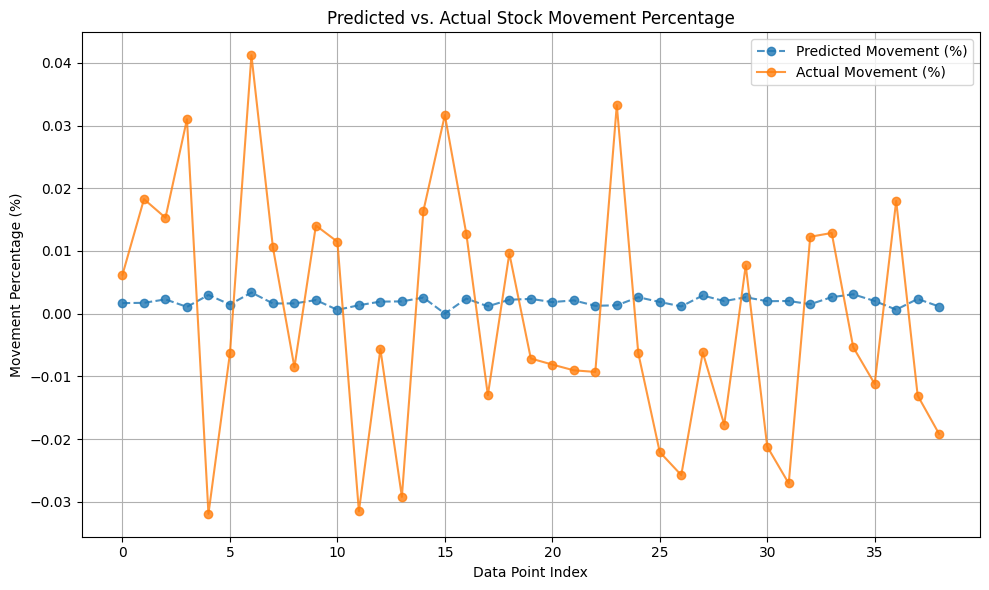

In [32]:

# Load the trained model
model.load_state_dict(torch.load("Results/ShallowRegressionLSTM.pth"))
model.to(device)

# Plot predicted vs. actual movement percentages for AAPL
predicted_movements, actual_movements = plot_movement_percent(model, company_data, device)
